In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import pylab as pl
from matplotlib import cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


# Time series clustering exercise

## Goal: Cluster zipcodes using time series on the yearly number of business

### Data sources:

Census bureau business data for all years 1993-2014.

NYC zipcodes shapefile, from NYC Open Data Portal: https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

### Data downloading and processing

In [3]:
#Helper function to download data and move to puidata folder
def getData(filename, url):
    #Check file
    if not os.path.isfile(puidata + '/' + filename):
        print ("Downloading {}".format(filename)) 
        os.system('curl -O ' + url)
        os.system("mv " + filename + " " + puidata)

    # Check:
    if not os.path.isfile(puidata + '/' + filename):
        print ("WARNING!!! Something is wrong: the file is not there!")

    else:
        print (filename + " in place, you can continue")

Download NYC zip codes shapefile and just keep the zipcodes for processing

In [4]:
#Download zipcodes shapefile
filename = 'ZIP_CODE_040114.zip'
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
getData(filename, url)

#unzip
zf = zipfile.ZipFile(puidata + '/' + filename)
zf.extractall(puidata)

#Load to geopandas
nyczipsshp = gpd.read_file(puidata + '/' + filename.replace('.zip','.shp'))

#Get unique zipcodes
#This is because some zipcodes have multiple polygons in the shapefile,
#but I don't want to have the zipcodes repeated for the analysis.
nyczips = np.unique(nyczipsshp.ZIPCODE.values.astype(int))

#Load into a dataframe
cbs = pd.DataFrame(nyczips, columns=['zip'])
cbs.head()

ZIP_CODE_040114.zip in place, you can continue


zip
0     83
1  10001
2  10002
3  10003
4  10004

In [5]:
print('We have {} zipcodes in total'.format(len(cbs)))

We have 248 zipcodes in total


Download the census business information at the zipcode level for each year, and add the number of business establishments to our NYC zip code dataframe. Each year will be a new column.

In [6]:
#Loop to download and read all files
for y in range(1994, 2015):
    #Get last 2 digits of year
    year = str(y)[2:]

    #Set filename and url
    filename = 'zbp{}totals.zip'.format(year)
    url = 'https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW12_fb55/' + filename

    #download data
    getData(filename, url)

    #Read zipfile and load to a dataframe
    zf = zipfile.ZipFile(puidata + '/' + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')))
    
    #Get only the columns we need
    #Some files have the columns in caps and others don't, nice
    #Rename the data column with the corresponding year
    try:
        df = df.loc[:,['zip', 'est']]
        df.rename(columns={'est':year}, inplace=True)
    except KeyError:
        df = df.loc[:,['ZIP', 'EST']]
        df.rename(columns={'ZIP':'zip', 'EST':year}, inplace=True)
    
    #Merge to our zip codes dataframe
    cbs = cbs.merge(df, on='zip', how='left')

cbs.head()

zbp94totals.zip in place, you can continue
zbp95totals.zip in place, you can continue
zbp96totals.zip in place, you can continue
zbp97totals.zip in place, you can continue
zbp98totals.zip in place, you can continue
zbp99totals.zip in place, you can continue
zbp00totals.zip in place, you can continue
zbp01totals.zip in place, you can continue
zbp02totals.zip in place, you can continue
zbp03totals.zip in place, you can continue
zbp04totals.zip in place, you can continue
zbp05totals.zip in place, you can continue
zbp06totals.zip in place, you can continue
zbp07totals.zip in place, you can continue
zbp08totals.zip in place, you can continue
zbp09totals.zip in place, you can continue
zbp10totals.zip in place, you can continue
zbp11totals.zip in place, you can continue
zbp12totals.zip in place, you can continue
zbp13totals.zip in place, you can continue
zbp14totals.zip in place, you can continue


zip      94      95      96      97      98      99      00      01  \
0     83     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1  10001  6999.0  7088.0  7075.0  7154.0  7254.0  7233.0  7317.0  7188.0   
2  10002  1784.0  1819.0  1919.0  2049.0  2003.0  2085.0  2277.0  2543.0   
3  10003  3256.0  3377.0  3417.0  3535.0  3649.0  3659.0  3683.0  3602.0   
4  10004  1115.0  1124.0  1133.0  1173.0  1176.0  1233.0  1294.0  1247.0   

       02   ...        05      06      07      08      09      10      11  \
0     NaN   ...       NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1  7141.0   ...    7312.0  7415.0  7549.0  7472.0  7305.0  7241.0  7227.0   
2  2269.0   ...    2682.0  2686.0  2685.0  2691.0  2775.0  2872.0  2912.0   
3  3616.0   ...    3867.0  3909.0  4049.0  4071.0  4099.0  4113.0  4159.0   
4  1253.0   ...    1260.0  1311.0  1370.0  1376.0  1379.0  1398.0  1404.0   

       12      13      14  
0     NaN     NaN     NaN  
1  7235.0  7273.0  7369.0  
2  2954.0  2988.0  2972.0  
3  4214.0  4277.0  4333.0  
4  1442.0  1479.0  1554.0  

[5 rows x 22 columns]

In [208]:
cbs.shape

(248, 22)

Data cleaning

In [7]:
#For later use (names of the data columns)
data_columns = [str(y)[2:] for y in range(1994, 2015)]

#Set zip as index and drop columns with all nans
cbs.set_index('zip', inplace=True)
cbs_clean = cbs.dropna(how='all')
cbs_clean.shape

(245, 21)

In [8]:
#Try to save some columns that have some Nans, doing back and front filling of 1 period.
cbs_clean = cbs.fillna(method='ffill', limit=1, axis=1)
cbs_clean = cbs.fillna(method='bfill', limit=1, axis=1)

#Only one zipcode is not dropped here thanks to what we just did above
cbs_clean = cbs_clean.dropna(how='any')
cbs_clean.shape

(231, 21)

Standardize the data on the row axis

In [9]:
#Standardize the data (every row)
cbs_standardized = ((cbs_clean.T - cbs_clean.mean(axis=1))/cbs_clean.std(axis=1)).T

### K-Means clustering

In [10]:
#Using 5 clusters
nc = 5

#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(cbs_standardized)
km.labels_.shape

(231,)

In [11]:
#Add labels to dataframe
cbs_standardized['kmeans'] = km.labels_ + 1

In [12]:
#Merge with shapefile for mapping
nyczipsshp['ZIPCODE'] = nyczipsshp.ZIPCODE.astype(int)
cbs_shp = nyczipsshp.merge(cbs_standardized, left_on='ZIPCODE', right_index=True, how='left')

#Add 0 for the zipcodes that were not clustered
cbs_shp.fillna(0, inplace=True)

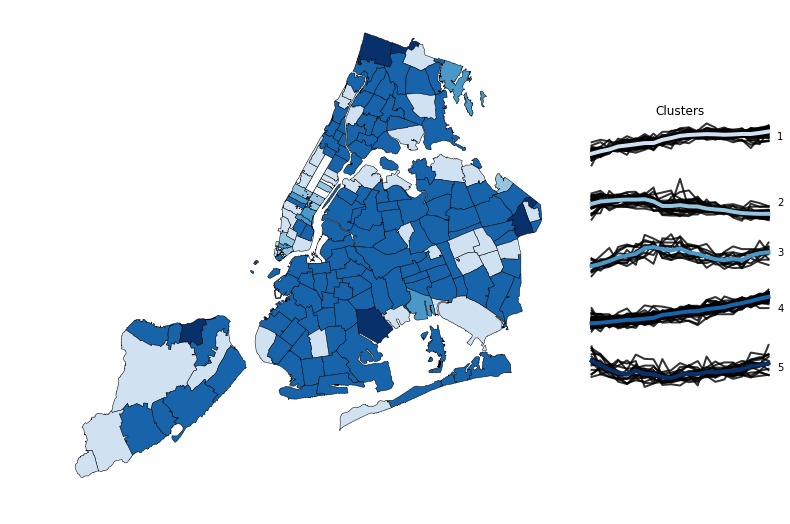

In [13]:
#Plot a map and the clustered time series
cmap = cm.get_cmap('Blues')
fig = pl.figure(figsize=(13,9))

for i in range(nc):
    
    cluster = cbs_standardized.loc[cbs_standardized.kmeans == (i+1),data_columns]
    
    ax = plt.subplot2grid((9, 7), (i+2, 5), colspan=2)
    
    if i == 0:
        ax.set_title('Clusters')
    
    for row, values in cluster.iterrows():
        
        ax.plot(range(len(data_columns)), values, 'k-', alpha=0.8, lw=2)
        
    ax.plot(range(len(data_columns)), cluster.mean(axis=0).values, '-', lw=4, color=cmap((i+1)/5))
    
    ax.annotate(s='{}'.format(i+1), xy=(ax.get_xlim()[1],0))

    ax.axis('off')

ax = plt.subplot2grid((9, 7), (0, 0), colspan=5, rowspan=9)

cbs_shp.plot(column='kmeans', ax=ax, cmap='Blues', edgecolor='k', lw=0.5)

ax.axis('off')

pl.show()

**Figure 1: Clusters of NYC Zipcodes using K-Means based on number of business establishments over 1994-2014.** On the left we see the map of NYC with the zipcodes colored by cluster, and on the right we see each of the 5 clusters with all its zipcode's time series and the cluster trend. We can that Cluster 1 and 4 have a sustained increasing trend, and together they cover most of the zipcodes on the map. Cluster 2 has a mostly constant number of business, with zipcodes located in Midtown and Lower Manhattan. Cluster 3 has zipcodes with a more irregluar trend, and Cluster 5 is decresing at first and then increasing slightly.

### Agglomerative Klustering

In [14]:
#using the same number of clusters for comparinson
agc = AgglomerativeClustering(n_clusters=nc, compute_full_tree=True, linkage='ward').fit(cbs_standardized[data_columns])
agc.labels_.shape

(231,)

In [15]:
#add labels to dataframe
cbs_standardized['agc'] = agc.labels_ + 1

In [16]:
#Merge with shapefile
cbs_shp = nyczipsshp.merge(cbs_standardized, left_on='ZIPCODE', right_index=True, how='left')

#Again, fill nans with zero (zipcodes droped in the preprocessing)
cbs_shp.fillna(0, inplace=True)

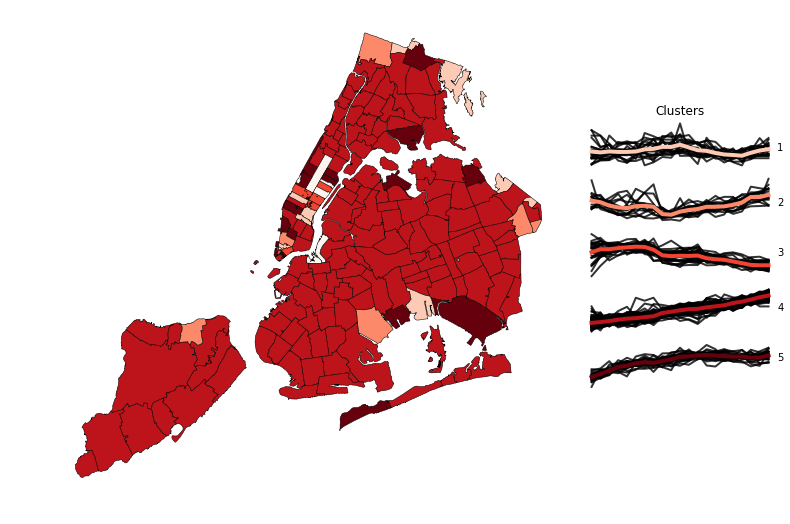

In [17]:
#Plot
cmap = cm.get_cmap('Reds')
fig = pl.figure(figsize=(13,9))

for i in range(nc):
    
    cluster = cbs_standardized.loc[cbs_standardized.agc == (i+1),data_columns]
    
    ax = plt.subplot2grid((9, 7), (i+2, 5), colspan=2)
    
    if i == 0:
        ax.set_title('Clusters')
    
    for row, values in cluster.iterrows():
        
        ax.plot(range(len(data_columns)), values, 'k-', alpha=0.8, lw=2)
        
    ax.plot(range(len(data_columns)), cluster.mean(axis=0).values, '-', lw=4, color=cmap((i+1)/5))
    
    ax.annotate(s='{}'.format(i+1), xy=(ax.get_xlim()[1],0))

    ax.axis('off')

ax = plt.subplot2grid((9, 7), (0, 0), colspan=5, rowspan=9)

cbs_shp.plot(column='agc', ax=ax, cmap='Reds', edgecolor='k', lw=0.5)

ax.axis('off')

pl.show()

**Figure 2: Clusters of NYC Zipcodes using Agglomerative Clustering based on number of business establishments over 1994-2014.** On the left we see the map of NYC with the zipcodes colored by cluster, and on the right we see each of the 5 clusters with all its zipcode's time series and the cluster trend. It seems like in this case the clusters are more different between each other.